In [89]:
import math
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import scipy.interpolate
import scipy.fftpack
import scipy.ndimage.interpolation
from skimage.transform import radon, rescale
import skimage

In [90]:
save_here = "C:/Users/tomerf/Desktop/reconstruction_examples_for_master/figures/"


In [91]:
# Object creation

# Create blank image
img_size = 512
phantom = np.zeros((img_size, img_size), dtype=np.uint8)

# Circle parameters
circle_center = (img_size // 2, img_size // 2)
circle_radius = 100
cv2.circle(phantom, circle_center, circle_radius, color=255, thickness=-1)

# Rectangle parameters (placed to the right of the circle)
rect_top_left = (img_size // 2 + 120, img_size // 2 - 160)
rect_bottom_right = (rect_top_left[0] + 60, rect_top_left[1] + 120)
cv2.rectangle(phantom, rect_top_left, rect_bottom_right, color=255, thickness=-1)

# Normalize to float [0,1] for Matplotlib
phantom_norm = phantom.astype(np.float32) / 255.0

C:\Users\tomerf\AppData\Local\Temp\ipykernel_2216\3176702415.py:35: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  scipy.ndimage.interpolation.rotate(


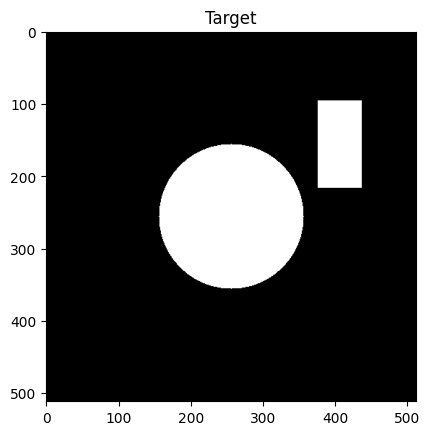

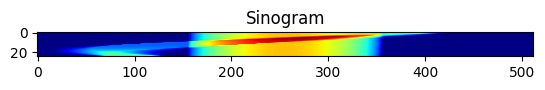

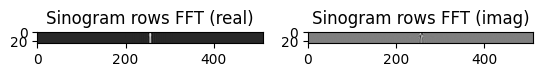

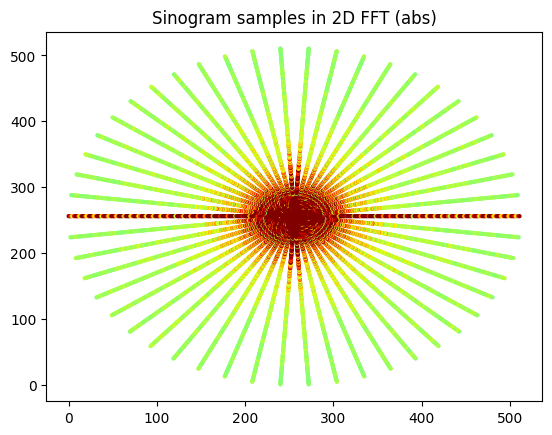

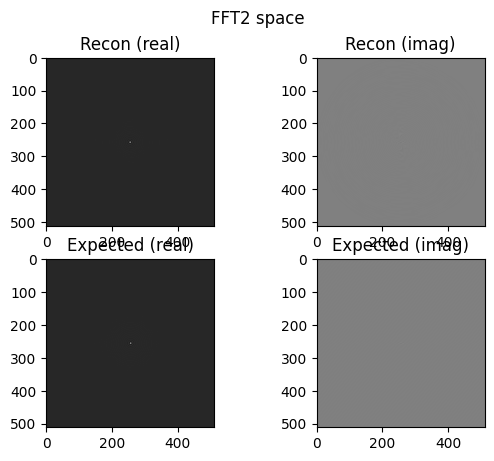

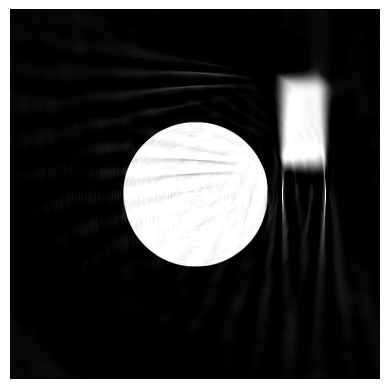

In [125]:
S = 512  # Size of target, and resolution of Fourier space
N = 25  # Number of sinogram exposures (odd number avoids redundant direct opposites)

V = 100  # Range on fft plots


# Convenience function
def sqr(x):
    return x * x


# Return the angle of the i-th (of 0-to-N-1) sinogram exposure in radians.
def angle(i):
    return (math.pi * i) / N


# Prepare a target image
x, y = np.meshgrid(np.arange(S) - S / 2, np.arange(S) - S / 2)
mask = sqr(x) + sqr(y) <= sqr(S / 2 - 10)
target = np.where(
    mask,
    skimage.transform.resize(phantom_norm, (S, S), anti_aliasing=True),
    np.zeros((S, S)),
)

plt.figure()
plt.title("Target")
plt.imshow(target)
plt.gray()

# Project the sinogram (ie calculate Radon transform)
sinogram = np.array(
    [
        np.sum(
            scipy.ndimage.interpolation.rotate(
                target,
                np.rad2deg(angle(i)),  # NB rotate takes degrees argument
                order=3,
                reshape=False,
                mode="constant",
                cval=0.0,
            ),
            axis=0,
        )
        for i in range(N)
    ]
)

plt.figure()
plt.title("Sinogram")
plt.imshow(sinogram)
plt.jet()

# Fourier transform the rows of the sinogram, move the DC component to the row's centre
sinogram_fft_rows = scipy.fftpack.fftshift(
    scipy.fftpack.fft(scipy.fftpack.ifftshift(sinogram, axes=1)), axes=1
)

plt.figure()
plt.subplot(121)
plt.title("Sinogram rows FFT (real)")
plt.imshow(np.real(sinogram_fft_rows),  cmap="gray")

plt.subplot(122)
plt.title("Sinogram rows FFT (imag)")
plt.imshow(np.imag(sinogram_fft_rows),  cmap="gray")


# Coordinates of sinogram FFT-ed rows' samples in 2D FFT space
a = np.array([angle(i) for i in range(N)])
r = np.arange(S) - S / 2
r, a = np.meshgrid(r, a)
r = r.flatten()
a = a.flatten()
srcx = (S / 2) + r * np.cos(a)
srcy = (S / 2) + r * np.sin(a)

# Coordinates of regular grid in 2D FFT space
dstx, dsty = np.meshgrid(np.arange(S), np.arange(S))
dstx = dstx.flatten()
dsty = dsty.flatten()

plt.figure()
plt.title("Sinogram samples in 2D FFT (abs)")
plt.scatter(
    srcx,
    srcy,
    c=np.absolute(sinogram_fft_rows.flatten()),
    marker=".",
    edgecolor="none",
    vmin=-V,
    vmax=V,
)

# Let the central slice theorem work its magic!
# Interpolate the 2D Fourier space grid from the transformed sinogram rows
fft2 = scipy.interpolate.griddata(
    (srcy, srcx),
    sinogram_fft_rows.flatten(),
    (dsty, dstx),
    method="cubic",
    fill_value=0.0,
).reshape((S, S))

plt.figure()
plt.suptitle("FFT2 space")
plt.subplot(221)
plt.title("Recon (real)")
plt.imshow(np.real(fft2), cmap="gray")
plt.subplot(222)
plt.title("Recon (imag)")
plt.imshow(np.imag(fft2),  cmap="gray")

# Show 2D FFT of target, just for comparison
expected_fft2 = scipy.fftpack.fftshift(
    scipy.fftpack.fft2(scipy.fftpack.ifftshift(target))
)

plt.subplot(223)
plt.title("Expected (real)")
plt.imshow(np.real(expected_fft2),  cmap="gray")
plt.subplot(224)
plt.title("Expected (imag)")
plt.imshow(np.imag(expected_fft2),  cmap="gray")

# Transform from 2D Fourier space back to a reconstruction of the target
recon = np.real(
    scipy.fftpack.fftshift(scipy.fftpack.ifft2(scipy.fftpack.ifftshift(fft2)))
)

plt.figure()
plt.axis("off")
plt.imshow(recon,  cmap="gray", vmin=0.0, vmax=1.0)
plt.gray()
plt.show()


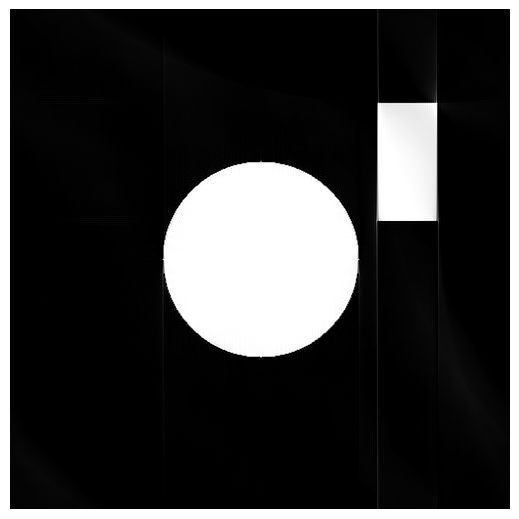

In [124]:
plt.figure(figsize=(5, 5))
plt.imshow(recon, cmap='gray', vmin=0.0, vmax=1.0)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig(save_here + "phantom_circle_rectangle_recon1000.pdf", format='pdf', bbox_inches='tight', pad_inches=0)
plt.show()